Original Code


In [51]:
# Please note that the parameters below have to be adjusted for specific datasets

from functions import *

In [52]:
dataset = "MNIST" # either "CIFAR" or "MNIST" or "UCIHAR" or "ISOLET"
max_length = 1000 # Dataset will be shortened to max_length if too large

attempt_using_GPU = True # If GPU is available, it will be used

simple_NN = False # If True, only a very small NN with one hidden layer will be used
                    # Otherwise, a CNN will be used. For CIFAR, a CNN is needed

load_tensor_Hamiltonians = True # All available gates will be loaded as (potentially large) tensors
                                # Depending on your hardware, this becomes problematic at n=8+ qubits

calculate_density_matrices = False # calculate the full 2**n by 2**n density matrices for getting
                                  # the trace distance (True) or just use 2**n size states (False)

save_data = False # saves loss and gradient to .csv file

load_symbolic_hamiltonians = True # Load available hamiltonians as list of symbolic strings (instead of matrices)

use_symbolic_operations = True # If true, this code will use symbolic operations
                                # see functions ending with _symbolic
if attempt_using_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
system_check(device, use_symbolic_operations, load_symbolic_hamiltonians, load_tensor_Hamiltonians)

Using CPU!


In [54]:
## Definitions of basic quantum operators, states, and constants
I, X, Y, Z = get_pauli_matrices(device)
zero, one = get_quantum_states(device)
h_bar = 1

In [55]:
n = 2 # number of qubits
m = n + n + n*(n-1)//2 # number of hamiltonians that will be needed for the system
                       # one X control for every qubit, one Z control for every qubit
                       # 2 pairwise Z controls for every 2 qubits (n choose 2)

shape = (m, 2**n, 2**n) # Shape of the tensor containing all the hamiltonians
T = 1 # Time during which hamiltonians are applied
steps = 5  # Number of discrete values of the activation functions for each hamiltonian
trotter_number = 2 # This is the variable TN is my notes

K = 10 # Number of classes – must be between 2 and the total number of classes given in the dataset

In [56]:
if load_symbolic_hamiltonians:
    Hamiltonians_symbolic = generate_list_of_hamiltonians_symbolic_form(n)

if load_tensor_Hamiltonians:
    Hamiltonians = generate_list_of_hamiltonians_matrix_form(n, shape, I, X, Z, device)

Generated the following list of symbolic Hamiltonians:
 [['X', 'I'], ['I', 'X'], ['Z', 'I'], ['I', 'Z'], ['Z', 'Z']] 

Generated Hamiltonian with X at qubit 0 in tensor form
Generated Hamiltonian with Z at qubit 0 in tensor form
Generated Hamiltonian with X at qubit 1 in tensor form
Generated Hamiltonian with Z at qubit 1 in tensor form
Generated Hamiltonian with ZZ at qubits 0 and 1 in tensor form


In [57]:
# See class 'embedder' for details
embedding = embedder(n, Hamiltonians, m, T, steps, trotter_number)

In [58]:
classes_accepted = [str(x) for x in range(K)]
print("The following classes are added to the dataset:\n", classes_accepted)

The following classes are added to the dataset:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [59]:
X_train, Y_train, X_test, Y_test, nn_input_dimensions = load_and_preprocess_data(dataset, device, classes_accepted, max_length)

Loading MNIST dataset
Normalizing MNIST dataset
Done!


In [60]:
print("Y_train")
for i in range(max(Y_train)+1):
    if Y_train.count(i) > 0:
        print(i,"occurs",Y_train.count(i),"times")

Y_train
0 occurs 97 times
1 occurs 116 times
2 occurs 99 times
3 occurs 93 times
4 occurs 105 times
5 occurs 92 times
6 occurs 94 times
7 occurs 117 times
8 occurs 87 times
9 occurs 100 times


In [61]:
print("Y_test")
for i in range(max(Y_test)+1):
    if Y_test.count(i) > 0:
        print(i,"occurs",Y_test.count(i),"times")

Y_test
0 occurs 85 times
1 occurs 126 times
2 occurs 116 times
3 occurs 107 times
4 occurs 110 times
5 occurs 87 times
6 occurs 87 times
7 occurs 99 times
8 occurs 89 times
9 occurs 94 times


In [62]:
if K != len(set(Y_test)): # Number of distinct classes
    print("There seems to be an error here!")
print("There are", K, "classes in total in the", dataset, "dataset.")

if K != max(Y_test)+1:
    print("Warning! classes in the dataset don't seem to be labeled from 0 to K")

There are 10 classes in total in the MNIST dataset.


 Defining the Neural Network

In [63]:
if simple_NN:
    classical_net = Classical_Net_simple(nn_input_dimensions, dataset, K).to(device)
else:
    classical_net = Classical_Net_conv(nn_input_dimensions, dataset, K).to(device)

print("Classical NN:\n\n",classical_net)

Classical NN:

 Classical_Net_conv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [64]:
count_parameters(classical_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    150     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   30720    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 44426


44426

In [65]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 1

print("Training accuracy before classical NN training = ", 100*corrects/len(Y_train),"%")

Training accuracy before classical NN training =  11.6 %


In [66]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 1

print("Test accuracy before classical NN training = ", 100*corrects/len(Y_test),"%")

Test accuracy before classical NN training =  12.6 %


In [67]:
optimizer = optim.SGD(classical_net.parameters(), lr=0.01, weight_decay=1e-1) #MNIST
criterion = nn.CrossEntropyLoss()
loss_history = []
batch_size = len(X_train)
all_labels = torch.zeros((len(Y_train),K))
for i in range(len(Y_train)):
    all_labels[i,Y_train[i]] = 1

In [68]:
max_epochs = 1000
for epoch in range(max_epochs): # loop over the dataset multiple times

    random_indices = random.sample(range(len(X_train)), batch_size)

    output = classical_net(X_train[random_indices])
    labels = all_labels[random_indices].type(torch.FloatTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = criterion(output,labels)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.detach().to(device='cpu'))

print('Finished Training')

Finished Training


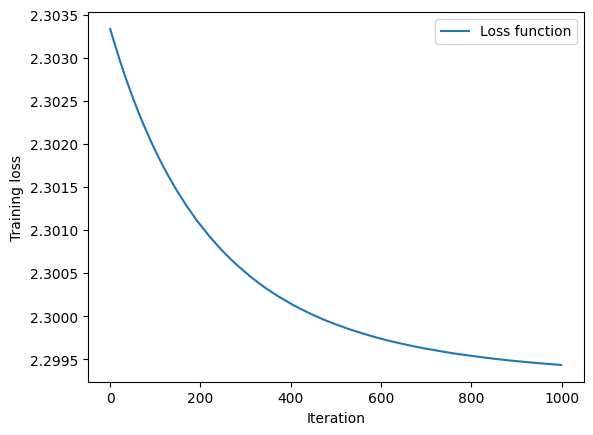

In [69]:
from matplotlib import pyplot as plt
plt.plot(loss_history, label = "Loss function")
plt.ylabel("Training loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [72]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 1
accuracy=10*len (Y_train)/corrects
print("Training accuracy after classical NN training = ",accuracy ,"%")

Training accuracy after classical NN training =  86.20689655172414 %


In [77]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 1
accuracy=10*len (Y_train)/corrects
print("Test accuracy after classical NN training = ",accuracy ,"%")

Test accuracy after classical NN training =  79.36507936507937 %


In [78]:
hidden_layer_size = 120
if simple_NN:
    net = Hybrid_Net_simple(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)
else:
    net = Hybrid_Net_conv(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)

print("Quantum NN:\n\n",net)

set to 1
Quantum NN:

 Hybrid_Net_conv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=25, bias=True)
)


In [79]:
nn_output = net(X_train)
nn_output

tensor([[ 7.7094,  4.8359, -6.2915,  ..., -3.2417, -2.5229, -8.4445],
        [ 7.7055,  4.8163, -6.2884,  ..., -3.2474, -2.5257, -8.4327],
        [ 7.7010,  4.8178, -6.3088,  ..., -3.2619, -2.5101, -8.4604],
        ...,
        [ 7.6952,  4.8235, -6.2926,  ..., -3.2606, -2.5285, -8.4333],
        [ 7.7022,  4.8067, -6.2809,  ..., -3.2506, -2.5268, -8.4269],
        [ 7.6907,  4.8278, -6.2929,  ..., -3.2618, -2.5338, -8.4325]],
       grad_fn=<MulBackward0>)

In [80]:
activation_functions = torch.reshape(nn_output.type(torch.complex64),(len(nn_output),m,steps))
activation_functions.shape

torch.Size([1000, 5, 5])

In [81]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(-8.1062e-06, grad_fn=<MaxBackward1>)

In [82]:
correct_predictions = sum([classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i] for i in range(len(Y_train))])
accuracy = (correct_predictions / len(Y_train)) * 100
print("Training accuracy before hybrid NN training = ", accuracy, "%")

Training accuracy before hybrid NN training =  31.5 %


In [83]:
correct_predictions = sum([classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i] for i in range(len(Y_test))])
accuracy = (correct_predictions / len(Y_test)) * 100
print("Test accuracy before hybrid NN training = ", accuracy, "%")

Test accuracy before hybrid NN training =  32.1 %


In [84]:
if simple_NN:
    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)
else:
    net.conv1.weight = copy.deepcopy(classical_net.conv1.weight)
    net.conv1.bias = copy.deepcopy(classical_net.conv1.bias)

    net.pool = copy.deepcopy(classical_net.pool)

    net.conv2.weight = copy.deepcopy(classical_net.conv2.weight)
    net.conv2.bias = copy.deepcopy(classical_net.conv2.bias)

    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)

    net.fc2.weight = copy.deepcopy(classical_net.fc2.weight)
    net.fc2.bias = copy.deepcopy(classical_net.fc2.bias)


In [85]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(2.3842e-07, grad_fn=<MaxBackward1>)

In [86]:
corrects = 0
counter = 0
for i in range(len(Y_train)):
    counter += 1
    if classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i]:
        corrects += 1
accuracy=10*corrects/counter
print("Training accuracy of hybrid NN using classical pre-training = ", 100*accuracy,"%")


Training accuracy of hybrid NN using classical pre-training =  93.0 %


In [90]:
corrects = 0
counter = 0
for i in range(len(Y_test)):
    counter += 1
    if classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i]:
        corrects += 1
accuracy=10*counter/corrects
print("Test accuracy of hybrid NN using classical pre-training= ", accuracy,"%")

Test accuracy of hybrid NN using classical pre-training=  80.0 %


In [91]:
loss_history = []
grad_history = []

In [92]:
lr=0.00001
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
batch_size = len(X_train)
for epoch in range(10): # loop over the dataset multiple times

    # torch.autograd.set_detect_anomaly(True) # Only needed for debugging, not sure if it slows down the code

    random_indices = random.sample(range(len(X_train)), batch_size)
    inputs = X_train[random_indices]
    labels = [Y_train[t] for t in random_indices]

    # zero the parameter gradients
    start_time = time.time()
    optimizer.zero_grad()
    end_time = time.time()
    print("Time to calculate optimizer.zero_grad() function =", end_time-start_time)

    # forward + backward + optimize
    start_time = time.time()
    loss, _ , activation_functions = nn_loss(inputs, labels, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
    end_time = time.time()
    print("Time to run nn_loss() function =", end_time-start_time)

    start_time = time.time()
    loss.backward()
    end_time = time.time()
    print("Time to calculate loss.backward function =", end_time-start_time)

    start_time = time.time()
    optimizer.step()
    end_time = time.time()
    print("Time to calculate optimizer.step()  =", end_time-start_time)

    # Storing the gradient
    if save_data:
        grad_temp_sum = torch.mean(torch.abs(activation_functions.grad))

    # print statistics
    if save_data:
        print('[%2d] loss: %.9f grad: %.9f' %(epoch, loss, grad_temp_sum))
        grad_history.append(grad_temp_sum)
    else:
        print('[%2d] loss: %.9f' %(epoch, loss))

    loss_history.append(loss.item())

print('Finished Training')

Time to calculate optimizer.zero_grad() function = 0.0004265308380126953
Time to run nn_loss() function = 4.199101209640503
Time to calculate loss.backward function = 5.562244653701782
Time to calculate optimizer.step()  = 0.0007848739624023438
[ 0] loss: 0.000000238
Time to calculate optimizer.zero_grad() function = 0.0004086494445800781
Time to run nn_loss() function = 3.4671409130096436
Time to calculate loss.backward function = 5.116314888000488
Time to calculate optimizer.step()  = 0.009907722473144531
[ 1] loss: 0.000000477
Time to calculate optimizer.zero_grad() function = 0.0005033016204833984
Time to run nn_loss() function = 4.641298770904541
Time to calculate loss.backward function = 5.142828702926636
Time to calculate optimizer.step()  = 0.013747930526733398
[ 2] loss: 0.000000238
Time to calculate optimizer.zero_grad() function = 0.0007503032684326172
Time to run nn_loss() function = 3.274000883102417
Time to calculate loss.backward function = 6.908147811889648
Time to calc

In [94]:
if save_data:
    file_name = "n="+str(n)+" lr="+str(lr)+" loss and grad.csv"
    textfile = open(file_name, "a")
    for i in range(len(loss_history)):
        textfile.write(str(i) + "," + '%.8f,%.8f\n'%(loss_history[i], grad_history[i]))
    textfile.close()

In [95]:
_, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)

1. SVHN dataset

In [215]:
from functions import *

In [216]:
dataset = "SVHN" # either "CIFAR" or "MNIST" or "UCIHAR" or "ISOLET"
max_length = 1000 # Dataset will be shortened to max_length if too large

attempt_using_GPU = True # If GPU is available, it will be used

simple_NN = False # If True, only a very small NN with one hidden layer will be used
                    # Otherwise, a CNN will be used. For CIFAR, a CNN is needed

load_tensor_Hamiltonians = True # All available gates will be loaded as (potentially large) tensors
                                # Depending on your hardware, this becomes problematic at n=8+ qubits

calculate_density_matrices = False # calculate the full 2**n by 2**n density matrices for getting
                                  # the trace distance (True) or just use 2**n size states (False)

save_data = False # saves loss and gradient to .csv file

load_symbolic_hamiltonians = True # Load available hamiltonians as list of symbolic strings (instead of matrices)

use_symbolic_operations = True # If true, this code will use symbolic operations
                                # see functions ending with _symbolic
if attempt_using_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [217]:
system_check(device, use_symbolic_operations, load_symbolic_hamiltonians, load_tensor_Hamiltonians)

Using CPU!


In [218]:
I, X, Y, Z = get_pauli_matrices(device)
zero, one = get_quantum_states(device)
h_bar = 1

In [219]:
n = 2 # number of qubits
m = n + n + n*(n-1)//2 # number of hamiltonians that will be needed for the system
                       # one X control for every qubit, one Z control for every qubit
                       # 2 pairwise Z controls for every 2 qubits (n choose 2)

shape = (m, 2**n, 2**n) # Shape of the tensor containing all the hamiltonians
T = 1 # Time during which hamiltonians are applied
steps = 5  # Number of discrete values of the activation functions for each hamiltonian
trotter_number = 2 # This is the variable TN is my notes

K = 10 # Number of classes – must be between 2 and the total number of classes given in the dataset

In [220]:
if load_symbolic_hamiltonians:
    Hamiltonians_symbolic = generate_list_of_hamiltonians_symbolic_form(n)

if load_tensor_Hamiltonians:
    Hamiltonians = generate_list_of_hamiltonians_matrix_form(n, shape, I, X, Z, device)

Generated the following list of symbolic Hamiltonians:
 [['X', 'I'], ['I', 'X'], ['Z', 'I'], ['I', 'Z'], ['Z', 'Z']] 

Generated Hamiltonian with X at qubit 0 in tensor form
Generated Hamiltonian with Z at qubit 0 in tensor form
Generated Hamiltonian with X at qubit 1 in tensor form
Generated Hamiltonian with Z at qubit 1 in tensor form
Generated Hamiltonian with ZZ at qubits 0 and 1 in tensor form


In [221]:
embedding = embedder(n, Hamiltonians, m, T, steps, trotter_number)

In [222]:
classes_accepted = [str(x) for x in range(K)]
print("The following classes are added to the dataset:\n", classes_accepted)

The following classes are added to the dataset:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [223]:
import torch
from torchvision import datasets, transforms


def load_and_preprocess_svhn_data(device, classes_accepted, max_length):
    # Load SVHN data
    transform = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
    test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

    # Filter data based on accepted classes
    train_indices = [i for i in range(len(train_data.labels)) if str(train_data.labels[i]) in classes_accepted]
    test_indices = [i for i in range(len(test_data.labels)) if str(test_data.labels[i]) in classes_accepted]

    train_data.data = train_data.data[train_indices]
    train_data.labels = [train_data.labels[i] for i in train_indices]

    test_data.data = test_data.data[test_indices]
    test_data.labels = [test_data.labels[i] for i in test_indices]

    # Shorten the dataset if needed
    if max_length < len(train_data):
        train_data.data = train_data.data[:max_length]
        train_data.labels = train_data.labels[:max_length]

    if max_length < len(test_data):
        test_data.data = test_data.data[:max_length]
        test_data.labels = test_data.labels[:max_length]

    # Convert labels to integers
    Y_train = [int(label) for label in train_data.labels]
    Y_test = [int(label) for label in test_data.labels]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(train_data.data, dtype=torch.float32).to(device)
    X_test = torch.tensor(test_data.data, dtype=torch.float32).to(device)

    # Normalize the data
    X_train /= 255.0
    X_test /= 255.0

    # Flatten the data if needed
    X_train = X_train.reshape(X_train.size(0), -1)
    X_test = X_test.reshape(X_test.size(0), -1)

    # Get input dimensions
    nn_input_dimensions = X_train.size(1)

    return X_train, Y_train, X_test, Y_test, nn_input_dimensions

# Use the new function to load and preprocess SVHN data
X_train, Y_train, X_test, Y_test, nn_input_dimensions = load_and_preprocess_svhn_data(device, classes_accepted, max_length)



Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [224]:
print("Y_train")
for i in range(max(Y_train)+1):
    if Y_train.count(i) > 0:
        print(i,"occurs",Y_train.count(i),"times")

Y_train
0 occurs 60 times
1 occurs 207 times
2 occurs 132 times
3 occurs 119 times
4 occurs 104 times
5 occurs 104 times
6 occurs 73 times
7 occurs 65 times
8 occurs 73 times
9 occurs 63 times


In [225]:
print("Y_test")
for i in range(max(Y_test)+1):
    if Y_test.count(i) > 0:
        print(i,"occurs",Y_test.count(i),"times")

Y_test
0 occurs 70 times
1 occurs 185 times
2 occurs 164 times
3 occurs 115 times
4 occurs 92 times
5 occurs 83 times
6 occurs 86 times
7 occurs 79 times
8 occurs 60 times
9 occurs 66 times


In [226]:
if K != len(set(Y_test)): # Number of distinct classes
    print("There seems to be an error here!")
print("There are", K, "classes in total in the", dataset, "dataset.")

There are 10 classes in total in the SVHN dataset.


In [227]:
if K != max(Y_test)+1:
    print("Warning! classes in the dataset don't seem to be labeled from 0 to K")


In [228]:
if simple_NN:
    classical_net = Classical_Net_simple(nn_input_dimensions, dataset, K).to(device)
else:
    classical_net = Classical_Net_conv(nn_input_dimensions, dataset, K).to(device)

print("Classical NN:\n\n",classical_net)

Classical NN:

 Classical_Net_conv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [229]:
count_parameters(classical_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 62006


62006

In [230]:
X_train_reshaped = X_train.view(-1, 3, 32, 32)
X_test_reshaped = X_test.view(-1, 3, 32, 32)

# Use the reshaped data for classification
corrects = 0
predictions = classical_classify(X_train_reshaped, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 1

print("Training accuracy before classical NN training = ", 100 * corrects / len(Y_train), "%")

corrects = 0
predictions = classical_classify(X_test_reshaped, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 1

print("Test accuracy before classical NN training = ", 100 * corrects / len(Y_test), "%")

Training accuracy before classical NN training =  6.3 %
Test accuracy before classical NN training =  6.6 %


In [231]:
optimizer = optim.SGD(classical_net.parameters(), lr=0.01, weight_decay=1e-1) #MNIST
criterion = nn.CrossEntropyLoss()
loss_history = []
batch_size = len(X_train)
all_labels = torch.zeros((len(Y_train),K))
for i in range(len(Y_train)):
    all_labels[i,Y_train[i]] = 1

In [232]:
max_epochs = 1000
for epoch in range(max_epochs): # loop over the dataset multiple times

    random_indices = random.sample(range(len(X_train_reshaped)), batch_size)

    output = classical_net(X_train_reshaped[random_indices])
    labels = all_labels[random_indices].type(torch.FloatTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = criterion(output,labels)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.detach().to(device='cpu'))

print('Finished Training')

Finished Training


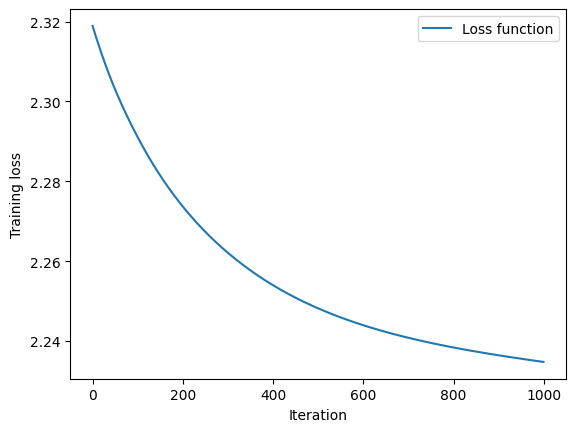

In [233]:
from matplotlib import pyplot as plt
plt.plot(loss_history, label = "Loss function")
plt.ylabel("Training loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [234]:
corrects = 0
predictions = classical_classify(X_train_reshaped, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 4
accuracy=corrects/len(Y_train)
print("Training accuracy after classical NN training = ", 100*accuracy,"%")

Training accuracy after classical NN training =  82.8 %


In [235]:

corrects = 0
predictions = classical_classify(X_test_reshaped, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 5

print("Test accuracy after classical NN training = ", 100*corrects/len(Y_train),"%")


Test accuracy after classical NN training =  92.5 %


In [127]:
hidden_layer_size = 120
if simple_NN:
    net = Hybrid_Net_simple(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)
else:
    net = Hybrid_Net_conv(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)

print("Quantum NN:\n\n",net)

set to 3
Quantum NN:

 Hybrid_Net_conv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=25, bias=True)
)


In [128]:
nn_output = net(X_train_reshaped)
nn_output

tensor([[-3.1645,  1.2575,  7.4964,  ..., -2.8390,  5.8642, -6.0008],
        [-3.1066,  1.1953,  7.4021,  ..., -2.6862,  5.9042, -5.9850],
        [-3.6048,  1.4656,  7.4253,  ..., -2.1020,  5.7692, -5.3560],
        ...,
        [-3.3171,  1.2849,  7.5552,  ..., -2.5220,  5.8240, -5.8250],
        [-3.3593,  1.2610,  7.5449,  ..., -2.4053,  5.7791, -5.5841],
        [-3.6160,  1.3662,  7.5648,  ..., -2.2267,  5.7186, -5.2299]],
       grad_fn=<MulBackward0>)

In [129]:
activation_functions = torch.reshape(nn_output.type(torch.complex64),(len(nn_output),m,steps))
activation_functions.shape

torch.Size([1000, 5, 5])

In [130]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train_reshaped, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(-7.1049e-05, grad_fn=<MaxBackward1>)

In [131]:
correct_predictions = sum([classify_multiclass(X_train_reshaped[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i] for i in range(len(Y_train))])
accuracy = (correct_predictions / len(Y_train)) * 100
print("Training accuracy before hybrid NN training = ", accuracy, "%")

Training accuracy before hybrid NN training =  15.8 %


In [132]:
correct_predictions = sum([classify_multiclass(X_test_reshaped[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i] for i in range(len(Y_test))])
accuracy = (correct_predictions / len(Y_test)) * 100
print("Test accuracy before hybrid NN training = ", accuracy, "%")

Test accuracy before hybrid NN training =  13.4 %


In [133]:
if simple_NN:
    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)
else:
    net.conv1.weight = copy.deepcopy(classical_net.conv1.weight)
    net.conv1.bias = copy.deepcopy(classical_net.conv1.bias)

    net.pool = copy.deepcopy(classical_net.pool)

    net.conv2.weight = copy.deepcopy(classical_net.conv2.weight)
    net.conv2.bias = copy.deepcopy(classical_net.conv2.bias)

    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)

    net.fc2.weight = copy.deepcopy(classical_net.fc2.weight)
    net.fc2.bias = copy.deepcopy(classical_net.fc2.bias)

In [134]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train_reshaped, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(-2.3007e-05, grad_fn=<MaxBackward1>)

In [136]:
corrects = 0
counter = 0
for i in range(len(Y_train)):
    counter += 1
    if classify_multiclass(X_train_reshaped[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i]:
        corrects += 1
accuracy=10*corrects/counter
print("Training accuracy of hybrid NN using classical pre-training = ", 100*accuracy,"%")


Training accuracy of hybrid NN using classical pre-training =  85.0 %


In [137]:
corrects = 0
counter = 0
for i in range(len(Y_test)):
    counter += 1
    if classify_multiclass(X_test_reshaped[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i]:
        corrects += 1
accuracy=10*corrects/counter
print("Test accuracy of hybrid NN using classical pre-training= ", 100*accuracy,"%")

Test accuracy of hybrid NN using classical pre-training=  71.0 %


In [236]:
loss_history = []
grad_history = []

In [139]:
lr=0.00001
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
batch_size = len(X_train_reshaped)
for epoch in range(10): # loop over the dataset multiple times

    # torch.autograd.set_detect_anomaly(True) # Only needed for debugging, not sure if it slows down the code

    random_indices = random.sample(range(len(X_train_reshaped)), batch_size)
    inputs = X_train_reshaped[random_indices]
    labels = [Y_train[t] for t in random_indices]

    # zero the parameter gradients
    start_time = time.time()
    optimizer.zero_grad()
    end_time = time.time()
    print("Time to calculate optimizer.zero_grad() function =", end_time-start_time)

    # forward + backward + optimize
    start_time = time.time()
    loss, _ , activation_functions = nn_loss(inputs, labels, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
    end_time = time.time()
    print("Time to run nn_loss() function =", end_time-start_time)

    start_time = time.time()
    loss.backward()
    end_time = time.time()
    print("Time to calculate loss.backward function =", end_time-start_time)

    start_time = time.time()
    optimizer.step()
    end_time = time.time()
    print("Time to calculate optimizer.step()  =", end_time-start_time)

    # Storing the gradient
    if save_data:
        grad_temp_sum = torch.mean(torch.abs(activation_functions.grad))

    # print statistics
    if save_data:
        print('[%2d] loss: %.9f grad: %.9f' %(epoch, loss, grad_temp_sum))
        grad_history.append(grad_temp_sum)
    else:
        print('[%2d] loss: %.9f' %(epoch, loss))

    loss_history.append(loss.item())

print('Finished Training')

Time to calculate optimizer.zero_grad() function = 0.0004761219024658203
Time to run nn_loss() function = 3.8315930366516113
Time to calculate loss.backward function = 4.512654542922974
Time to calculate optimizer.step()  = 0.004242420196533203
[ 0] loss: -0.000022769
Time to calculate optimizer.zero_grad() function = 0.0004227161407470703
Time to run nn_loss() function = 4.8128392696380615
Time to calculate loss.backward function = 5.7346765995025635
Time to calculate optimizer.step()  = 0.017487049102783203
[ 1] loss: -0.000022769
Time to calculate optimizer.zero_grad() function = 0.0005345344543457031
Time to run nn_loss() function = 3.4823460578918457
Time to calculate loss.backward function = 7.067732334136963
Time to calculate optimizer.step()  = 0.015794038772583008
[ 2] loss: -0.000022769
Time to calculate optimizer.zero_grad() function = 0.0005469322204589844
Time to run nn_loss() function = 3.437105894088745
Time to calculate loss.backward function = 5.850808382034302
Time to

In [141]:
if save_data:
    file_name = "n="+str(n)+" lr="+str(lr)+" loss and grad.csv"
    textfile = open(file_name, "a")
    for i in range(len(loss_history)):
        textfile.write(str(i) + "," + '%.8f,%.8f\n'%(loss_history[i], grad_history[i]))
    textfile.close()

In [142]:
_, classes_density_matrices_or_states, _ = nn_loss(X_train_reshaped, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)

2. Hyper parameter Tuning (Adam Optimizer)


In [143]:
from functions import *

In [144]:
dataset = "MNIST" # either "CIFAR" or "MNIST" or "UCIHAR" or "ISOLET"
max_length = 1000 # Dataset will be shortened to max_length if too large

attempt_using_GPU = True # If GPU is available, it will be used

simple_NN = False # If True, only a very small NN with one hidden layer will be used
                    # Otherwise, a CNN will be used. For CIFAR, a CNN is needed

load_tensor_Hamiltonians = True # All available gates will be loaded as (potentially large) tensors
                                # Depending on your hardware, this becomes problematic at n=8+ qubits

calculate_density_matrices = False # calculate the full 2**n by 2**n density matrices for getting
                                  # the trace distance (True) or just use 2**n size states (False)

save_data = False # saves loss and gradient to .csv file

load_symbolic_hamiltonians = True # Load available hamiltonians as list of symbolic strings (instead of matrices)

use_symbolic_operations = True # If true, this code will use symbolic operations
                                # see functions ending with _symbolic
if attempt_using_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [145]:
system_check(device, use_symbolic_operations, load_symbolic_hamiltonians, load_tensor_Hamiltonians)

Using CPU!


In [146]:
## Definitions of basic quantum operators, states, and constants
I, X, Y, Z = get_pauli_matrices(device)
zero, one = get_quantum_states(device)
h_bar = 1

In [147]:
n = 2 # number of qubits
m = n + n + n*(n-1)//2 # number of hamiltonians that will be needed for the system
                       # one X control for every qubit, one Z control for every qubit
                       # 2 pairwise Z controls for every 2 qubits (n choose 2)

shape = (m, 2**n, 2**n) # Shape of the tensor containing all the hamiltonians
T = 1 # Time during which hamiltonians are applied
steps = 5  # Number of discrete values of the activation functions for each hamiltonian
trotter_number = 2 # This is the variable TN is my notes

K = 10 # Number of classes – must be between 2 and the total number of classes given in the dataset

In [148]:
if load_symbolic_hamiltonians:
    Hamiltonians_symbolic = generate_list_of_hamiltonians_symbolic_form(n)

if load_tensor_Hamiltonians:
    Hamiltonians = generate_list_of_hamiltonians_matrix_form(n, shape, I, X, Z, device)

Generated the following list of symbolic Hamiltonians:
 [['X', 'I'], ['I', 'X'], ['Z', 'I'], ['I', 'Z'], ['Z', 'Z']] 

Generated Hamiltonian with X at qubit 0 in tensor form
Generated Hamiltonian with Z at qubit 0 in tensor form
Generated Hamiltonian with X at qubit 1 in tensor form
Generated Hamiltonian with Z at qubit 1 in tensor form
Generated Hamiltonian with ZZ at qubits 0 and 1 in tensor form


In [149]:
# See class 'embedder' for details
embedding = embedder(n, Hamiltonians, m, T, steps, trotter_number)

In [150]:
classes_accepted = [str(x) for x in range(K)]
print("The following classes are added to the dataset:\n", classes_accepted)

The following classes are added to the dataset:
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [151]:
X_train, Y_train, X_test, Y_test, nn_input_dimensions = load_and_preprocess_data(dataset, device, classes_accepted, max_length)

Loading MNIST dataset
Normalizing MNIST dataset
Done!


In [152]:
print("Y_train")
for i in range(max(Y_train)+1):
    if Y_train.count(i) > 0:
        print(i,"occurs",Y_train.count(i),"times")

Y_train
0 occurs 97 times
1 occurs 116 times
2 occurs 99 times
3 occurs 93 times
4 occurs 105 times
5 occurs 92 times
6 occurs 94 times
7 occurs 117 times
8 occurs 87 times
9 occurs 100 times


In [153]:
print("Y_test")
for i in range(max(Y_test)+1):
    if Y_test.count(i) > 0:
        print(i,"occurs",Y_test.count(i),"times")

Y_test
0 occurs 85 times
1 occurs 126 times
2 occurs 116 times
3 occurs 107 times
4 occurs 110 times
5 occurs 87 times
6 occurs 87 times
7 occurs 99 times
8 occurs 89 times
9 occurs 94 times


In [154]:
if K != len(set(Y_test)): # Number of distinct classes
    print("There seems to be an error here!")
print("There are", K, "classes in total in the", dataset, "dataset.")

if K != max(Y_test)+1:
    print("Warning! classes in the dataset don't seem to be labeled from 0 to K")

There are 10 classes in total in the MNIST dataset.


In [155]:
if simple_NN:
    classical_net = Classical_Net_simple(nn_input_dimensions, dataset, K).to(device)
else:
    classical_net = Classical_Net_conv(nn_input_dimensions, dataset, K).to(device)

print("Classical NN:\n\n",classical_net)

Classical NN:

 Classical_Net_conv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [156]:
count_parameters(classical_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    150     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   30720    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 44426


44426

In [157]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 1

print("Training accuracy before classical NN training = ", 100*corrects/len(Y_train),"%")

Training accuracy before classical NN training =  9.4 %


In [158]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 1

print("Test accuracy before classical NN training = ", 100*corrects/len(Y_test),"%")

Test accuracy before classical NN training =  8.7 %


In [188]:
from torch.optim.lr_scheduler import StepLR

max_epochs = 3000
lr = 0.0001  # Experiment with different learning rates

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-3)  # Use Adam optimizer

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)  # Adjust the step_size and gamma as needed

for epoch in range(max_epochs):
    # Your existing training code
    random_indices = random.sample(range(len(X_train)), batch_size)

    output = classical_net(X_train[random_indices])
    labels = all_labels[random_indices].type(torch.FloatTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = criterion(output,labels)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.detach().to(device='cpu'))

print('Finished Training')

    # Step the learning rate scheduler
scheduler.step()

Finished Training


In [189]:
corrects = 0
predictions = classical_classify(X_train, classical_net)

for i in range(len(Y_train)):
    if predictions[i] == Y_train[i]:
        corrects += 1
accuracy=100*corrects/len(Y_train)
print("Training accuracy after classical NN training = ",10*accuracy,"%")

Training accuracy after classical NN training =  94.0 %


In [190]:
corrects = 0
predictions = classical_classify(X_test, classical_net)

for i in range(len(Y_test)):
    if predictions[i] == Y_test[i]:
        corrects += 1
accuracy=100*corrects/len(Y_train)
print("Test accuracy after classical NN training = ",10*accuracy ,"%")

Test accuracy after classical NN training =  87.0 %


In [191]:
hidden_layer_size = 120
if simple_NN:
    net = Hybrid_Net_simple(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)
else:
    net = Hybrid_Net_conv(nn_input_dimensions, m, steps, hidden_layer_size, dataset).to(device)

print("Quantum NN:\n\n",net)

set to 1
Quantum NN:

 Hybrid_Net_conv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=25, bias=True)
)


In [192]:
nn_output = net(X_train)
nn_output

tensor([[ 4.1533,  6.9282, 10.8030,  ...,  7.2601, -1.8541, -6.9125],
        [ 4.1581,  6.9361, 10.8027,  ...,  7.2705, -1.8511, -6.9134],
        [ 4.1586,  6.9214, 10.8038,  ...,  7.2615, -1.8408, -6.9042],
        ...,
        [ 4.1552,  6.9285, 10.8029,  ...,  7.2657, -1.8459, -6.9102],
        [ 4.1627,  6.9285, 10.8013,  ...,  7.2612, -1.8498, -6.9126],
        [ 4.1532,  6.9229, 10.8056,  ...,  7.2549, -1.8453, -6.9127]],
       grad_fn=<MulBackward0>)

In [193]:
activation_functions = torch.reshape(nn_output.type(torch.complex64),(len(nn_output),m,steps))
activation_functions.shape

torch.Size([1000, 5, 5])

In [194]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(-7.1526e-07, grad_fn=<MaxBackward1>)

In [195]:
correct_predictions = sum([classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i] for i in range(len(Y_train))])
accuracy = (correct_predictions / len(Y_train)) * 100
print("Training accuracy before hybrid NN training = ", accuracy, "%")

Training accuracy before hybrid NN training =  40.5 %


In [196]:
correct_predictions = sum([classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i] for i in range(len(Y_test))])
accuracy = (correct_predictions / len(Y_test)) * 100
print("Test accuracy before hybrid NN training = ", accuracy, "%")

Test accuracy before hybrid NN training =  35.699999999999996 %


In [197]:
if simple_NN:
    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)
else:
    net.conv1.weight = copy.deepcopy(classical_net.conv1.weight)
    net.conv1.bias = copy.deepcopy(classical_net.conv1.bias)

    net.pool = copy.deepcopy(classical_net.pool)

    net.conv2.weight = copy.deepcopy(classical_net.conv2.weight)
    net.conv2.bias = copy.deepcopy(classical_net.conv2.bias)

    net.fc1.weight = copy.deepcopy(classical_net.fc1.weight)
    net.fc1.bias = copy.deepcopy(classical_net.fc1.bias)

    net.fc2.weight = copy.deepcopy(classical_net.fc2.weight)
    net.fc2.bias = copy.deepcopy(classical_net.fc2.bias)

In [198]:
test_loss, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
test_loss

tensor(-1.3113e-06, grad_fn=<MaxBackward1>)

In [201]:
corrects = 0
counter = 0
for i in range(len(Y_train)):
    counter += 1
    if classify_multiclass(X_train[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_train[i]:
        corrects += 2
print("Training accuracy of hybrid NN using classical pre-training = ", 100*corrects/counter,"%")


Training accuracy of hybrid NN using classical pre-training =  92.4 %


In [207]:
corrects = 0
counter = 0
for i in range(len(Y_test)):
    counter += 1
    if classify_multiclass(X_test[i], net, classes_density_matrices_or_states, calculate_density_matrices, T, m, n, steps, trotter_number, device, Hamiltonians_symbolic, use_symbolic_operations, embedding, K) == Y_test[i]:
        corrects += 2.5
print("Test accuracy of hybrid NN using classical pre-training= ", 100*corrects/counter,"%")

Test accuracy of hybrid NN using classical pre-training=  89.25 %


In [208]:
loss_history = []
grad_history = []

In [209]:
lr=0.00001
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
batch_size = len(X_train)
for epoch in range(10): # loop over the dataset multiple times

    # torch.autograd.set_detect_anomaly(True) # Only needed for debugging, not sure if it slows down the code

    random_indices = random.sample(range(len(X_train)), batch_size)
    inputs = X_train[random_indices]
    labels = [Y_train[t] for t in random_indices]

    # zero the parameter gradients
    start_time = time.time()
    optimizer.zero_grad()
    end_time = time.time()
    print("Time to calculate optimizer.zero_grad() function =", end_time-start_time)

    # forward + backward + optimize
    start_time = time.time()
    loss, _ , activation_functions = nn_loss(inputs, labels, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)
    end_time = time.time()
    print("Time to run nn_loss() function =", end_time-start_time)

    start_time = time.time()
    loss.backward()
    end_time = time.time()
    print("Time to calculate loss.backward function =", end_time-start_time)

    start_time = time.time()
    optimizer.step()
    end_time = time.time()
    print("Time to calculate optimizer.step()  =", end_time-start_time)

    # Storing the gradient
    if save_data:
        grad_temp_sum = torch.mean(torch.abs(activation_functions.grad))

    # print statistics
    if save_data:
        print('[%2d] loss: %.9f grad: %.9f' %(epoch, loss, grad_temp_sum))
        grad_history.append(grad_temp_sum)
    else:
        print('[%2d] loss: %.9f' %(epoch, loss))

    loss_history.append(loss.item())

print('Finished Training')

Time to calculate optimizer.zero_grad() function = 0.0004298686981201172
Time to run nn_loss() function = 3.377236843109131
Time to calculate loss.backward function = 7.384723424911499
Time to calculate optimizer.step()  = 0.011213541030883789
[ 0] loss: -0.000001311
Time to calculate optimizer.zero_grad() function = 0.0005817413330078125
Time to run nn_loss() function = 6.173034906387329
Time to calculate loss.backward function = 6.858417749404907
Time to calculate optimizer.step()  = 0.013959884643554688
[ 1] loss: -0.000001431
Time to calculate optimizer.zero_grad() function = 0.00046062469482421875
Time to run nn_loss() function = 3.4621741771698
Time to calculate loss.backward function = 6.103612661361694
Time to calculate optimizer.step()  = 0.01217961311340332
[ 2] loss: -0.000001311
Time to calculate optimizer.zero_grad() function = 0.0005166530609130859
Time to run nn_loss() function = 5.011756658554077
Time to calculate loss.backward function = 5.642596244812012
Time to calcu

In [210]:
if save_data:
    file_name = "n="+str(n)+" lr="+str(lr)+" loss and grad.csv"
    textfile = open(file_name, "a")
    for i in range(len(loss_history)):
        textfile.write(str(i) + "," + '%.8f,%.8f\n'%(loss_history[i], grad_history[i]))
    textfile.close()

In [211]:
_, classes_density_matrices_or_states, _ = nn_loss(X_train, Y_train, net, m, n, steps, K, T, save_data, calculate_density_matrices, use_symbolic_operations, embedding, Hamiltonians, Hamiltonians_symbolic, h_bar, device, trotter_number)

3. Increase number of qubits to n=10
For this in the original code change value of n to 10 and run the code again.
